# PROJETO INSIDERS CLUSTERING

# PLANEJAMENTO DA SOLUÇÃO

## Input - Entrada

1. Problema de Negócio

 - Selecionar os clientes mais valiosos para integrar um programa de Fidelização;
 
 
2. Conjunto de Dados

 - Vendas de um e-commerce online, durante o período de um ano.

## Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders:

  - Lista com o id_cliente e a classe se pertence ou não ao grupo de insiders.
  
  
2. Relatório com as respostas das perguntas de negócio:

  - Quem são as pessoas elegíveis para participar do programa de Insiders ?
  - Quantos clientes farão parte do grupo?
  - Quais as principais características desses clientes ?
  - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
  - Qual a expectativa de faturamento desse grupo para os próximos meses ?
  - Quais as condições para uma pessoa ser elegível ao Insiders ?
  - Quais as condições para uma pessoa ser removida do Insiders ?
  - Qual a garantia que o programa Insiders é melhor que o restante da base ?
  - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

  - O que é ser elegível? O que são clientes de maior "valor"?
  - Avaliar clientes em relação ao
    - Faturamento: 
      - Alto ticket médio;
      - Alto LTV; 
      - Baixa recência; 
      - Alto basket size;
      - Baixa probabilidade de churn;
      - Alta propensão de compra.
       
    - Custo:  
      - Baixa taxa de devolução.
           
    - Experiência de compra:  
      - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?

  - Número total de clientes;
  - Representatividade do grupo Insiders.
  

3. Quais as principais características desses clientes?

  - Características do cliente:
    - Idade;
    - Localização;
    - Gênero.
    
   - Características do consumo:
    - Atributos da clusterização.


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

  - Faturamento total do ano;
  - Faturamento vindo dos insiders.


5. Qual a expectativa de faturamento desse grupo para os próximos meses?

  - LTV do grupo Insiders;
  - Análise de Cohort.  


6. Quais as condições para uma pessoa ser elegível ao Insiders?

  - Definir periodicidade de execução do modelo;
  - A pessoa precisa ser similar ou parecido com o grupo Insiders.
  

7. Quais as condições para uma pessoa ser removida do Insiders?

  - Definir a periodicidade;
  - A pessoa precisa ser dissimilar ou não parecido com o grupo Insiders.


8. Qual a garantia que o programa Insiders é melhor que o restante da base?

  - Teste A/B;
  - Teste A/B Bayesiano;
  - Teste de hipóteses.


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

  - Desconto;
  - Preferência de compra;
  - Frete grátis.

# 0.0 IMPORTAÇÕES

## 0.1 Bibliotecas

In [1]:
import pandas                       as pd
import numpy                        as np
import matplotlib.pyplot            as plt
import seaborn                      as sns
import plotly.express               as px
import umap.umap_                   as umap
import re  
  
  
  
from sklearn import cluster         as c
from sklearn import metrics         as m
from sklearn import preprocessing   as pp
from sklearn import decomposition   as dd
from sklearn import ensemble        as en
from sklearn import manifold        as mn
from sklearn import mixture         as mx


from scipy.cluster import hierarchy as hc

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pandas_profiling import ProfileReport

from sklearn.neighbors import NearestNeighbors

sns.set()

## 0.2 Funções de suporte

## 0.3 Dataset

In [2]:
# carregando os dados

df_raw = pd.read_csv('Data/Ecommerce.csv', encoding='iso-8859-1')

# excluindo variável irrelevante

df_raw.drop(columns=['Unnamed: 8'], axis=1, inplace=True)

In [3]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 Data dimensions

In [6]:
print('Número de observações: {}'.format(df1.shape[0]))
print('Número de variáveis: {}'.format(df1.shape[1]))

Número de observações: 541909
Número de variáveis: 8


## 1.3 Tipagem dos dados

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Verificando dados faltantes

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Substituindo dados faltantes

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(),:]

df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [10]:
# criando referência

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge 

df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop colunas extras

df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Modificando a tipagem de dados

In [12]:
# invoice date

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id

df1['customer_id'] = np.int64(df1['customer_id'])

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Estatatística descritiva

In [14]:
num_attributes = df1.select_dtypes(include=['int32','int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Variáveis numéricas

In [15]:
# tendencia central

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersão 

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenar

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Investigando dados estranhos

1. Quantity negativa (pode ser devolução)

2. Preço unitário igual a zero (pode ser promoção)

### 1.7.2 Variáveis categóricas

In [16]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### 1.7.2.1 Invoice No

In [17]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

len(df_letter_invoices), len(df_letter_invoices[df_letter_invoices['quantity']<0])

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### 1.7.2.2 Stock Code

In [18]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# ação:
## remover stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### 1.7.2.3 Country

In [19]:
len(df1['country'].unique())

38

In [20]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [21]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 FILTRAGEM DE VARIÁVEIS

In [22]:
df2 = df1.copy()

In [23]:
# numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# categorical attributes
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 
                                    'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]


# 3.0 FEATURE ENGINEERING

In [24]:
df3 = df2.copy()

## 3.1 Criação de feature

In [25]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1 Receita

In [26]:
# gross revenue ( faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\herna\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\herna\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recência

In [27]:
# recency - last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

### 3.1.3 Quantidade de compras

In [28]:
# numero de compras
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )


### 3.1.4 Quantidade de produtos comprados

In [29]:
# numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )


### 3.1.5 Ticket médio

In [30]:
# avg ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

### 3.1.6 Average Recency Days

In [31]:
# average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )


###  3.1.7 Frequency Purchase

In [32]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# frequência
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )


### 3.1.8 Número de devoluções

In [33]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9 Basket size

- Invoice No = Compra = purchase
- Stock Code = Produto = Product
- Quantity = Item = Item

In [34]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.10 Quantidade de produtos distintos por compra

In [35]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [36]:
df4 = df_ref.dropna().copy()

## 4.1 Análise univariada

- Clusters Coesos - Separados
- Métricas
 - Min; 
 - Máximo;
 - Range (Dispersão);
 - Média e Mediana;
 - Desvio Padrão e Variância;
 - Coeficiente de Variação (CV);
 - Distribuição.

In [37]:
#profile = ProfileReport(df4)

#profile.to_file('output.html')

## 4.2 Análise bivariada

In [38]:
cols=['customer_id']
df42 = df4.drop(cols, axis=1)

In [39]:
#plt.figure(figsize=(25, 12))

#sns.pairplot(df42)

## 4.3 Estudo do espaço

In [40]:
df43 = df4.copy()

df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [41]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])

df43['recency_days']           = mm.fit_transform(df43[['recency_days']])

df43['qtde_invoices']          = mm.fit_transform(df43[['qtde_invoices']])

df43['qtde_products']          = mm.fit_transform(df43[['qtde_products']])

df43['avg_ticket']             = mm.fit_transform(df43[['avg_ticket']])

df43['avg_recency_days']       = mm.fit_transform(df43[['avg_recency_days']])

df43['frequency']              = mm.fit_transform(df43[['frequency']])

df43['qtde_returns']           = mm.fit_transform(df43[['qtde_returns']])

df43['avg_basket_size']        = mm.fit_transform(df43[['avg_basket_size']])

df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

### 4.3.1 PCA

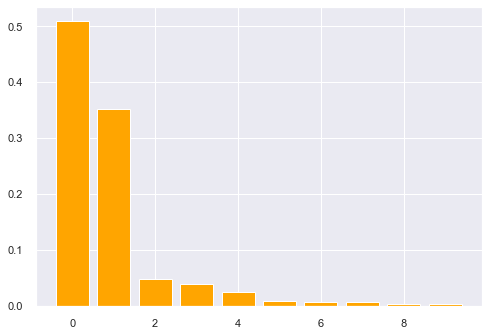

In [42]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='orange')

# pca components

df_pca = pd.DataFrame(principal_components)

In [43]:
df_pca.rename(columns={0: 'pca_0', 1:'pca_1'}, inplace=True)

<AxesSubplot:xlabel='pca_0', ylabel='pca_1'>

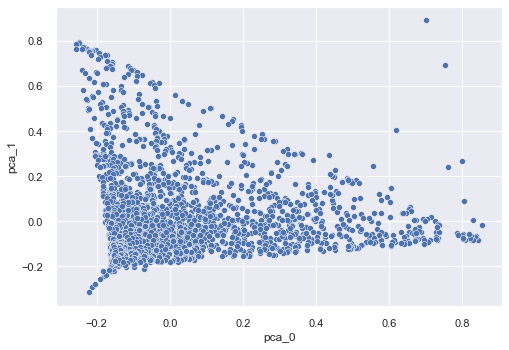

In [44]:
sns.scatterplot( x='pca_0', y='pca_1', data=df_pca )

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

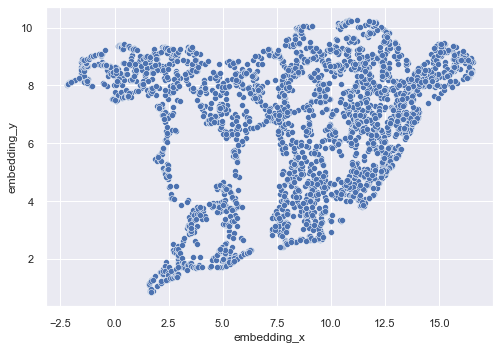

In [45]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

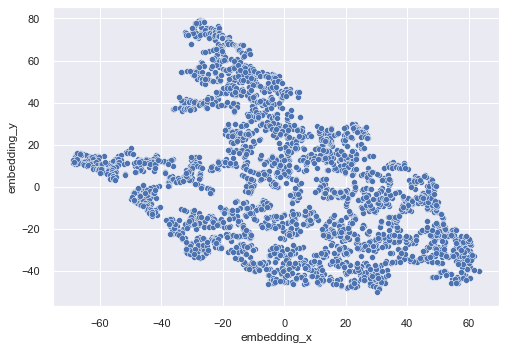

In [46]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.4 Tree-Based Embedding

In [47]:
# training dataset

X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition

rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training

rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [48]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [49]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3555,3520,3649,3566,3513,3711,3635,3575,3537,3614,...,3526,3454,3527,3474,3625,3544,3517,3726,3598,3720
1,3093,2965,2948,3069,2986,3005,2984,2993,3093,3075,...,2904,2878,3065,2991,3059,3064,3060,2904,3030,2968
2,3602,3659,3543,3646,3588,3614,3548,3408,3690,3551,...,3601,3595,3476,3551,3659,3634,3663,3630,3444,3665
3,1905,1742,2526,1958,1769,1931,1892,1812,1696,1934,...,2494,1810,624,1364,1513,1872,1939,1728,776,1861
4,482,485,523,483,543,555,505,515,530,393,...,816,443,510,513,255,426,483,484,249,194


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

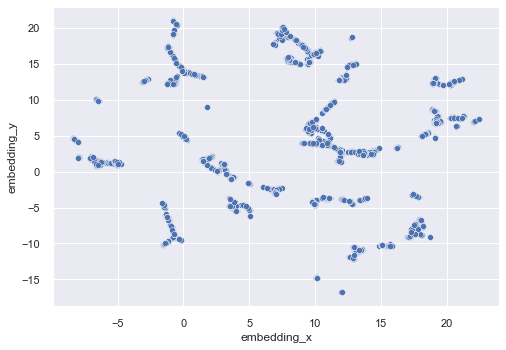

In [50]:
 # reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 5.0 PREPARAÇÃO DOS DADOS

- Distribuiçåo Normal e não possui Outlier -> Standard Scaler - Media e desvio padrao
- Distribuiçåo Normal e possuí Outlier -> Robust Scaler - Quartis
- Não distribuição normal -> Min Max Scaler

In [51]:
#df5 = df4.copy()
df5 = df_tree.copy()

In [52]:
df5.head()

,embedding_x,embedding_y
0,-0.707607,15.746873
1,4.932468,-1.578209
2,-0.972332,12.778666
3,-8.061130,4.227278
4,19.736347,12.075406


In [53]:
mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()


#df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
#df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
##df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
##df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
##df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
##df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
##df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
##df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )


# 6.0 FEATURE SELECTION

In [54]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [55]:
#df6 = df5[cols_selected].copy()
df6 = df_tree.copy()

# 7.0 HYPERPARAMETER FOR FINE-TUNNING

In [56]:
#X = df6.drop( columns=['customer_id'] )
X = df_tree.copy()

In [57]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange(2,25,1)

In [58]:
X

,embedding_x,embedding_y
0,-0.707607,15.746873
1,4.932468,-1.578209
2,-0.972332,12.778666
3,-8.061130,4.227278
4,19.736347,12.075406
...,...,...
2963,17.479942,-3.131870
2964,18.097782,4.989164
2965,14.233129,2.404952
2966,12.031842,-16.766115


## 7.1 K-Means

In [59]:
from sklearn import metrics         as m
kmeans_list = []
for k in clusters:

    # model definition
    
    kmeans_model = c.KMeans(n_clusters=k)
    
    # model training
    
    kmeans_model.fit(X)
    
    # model predict
    
    labels = kmeans_model.predict(X)
    
    # model performance
    
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'KMEANS: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

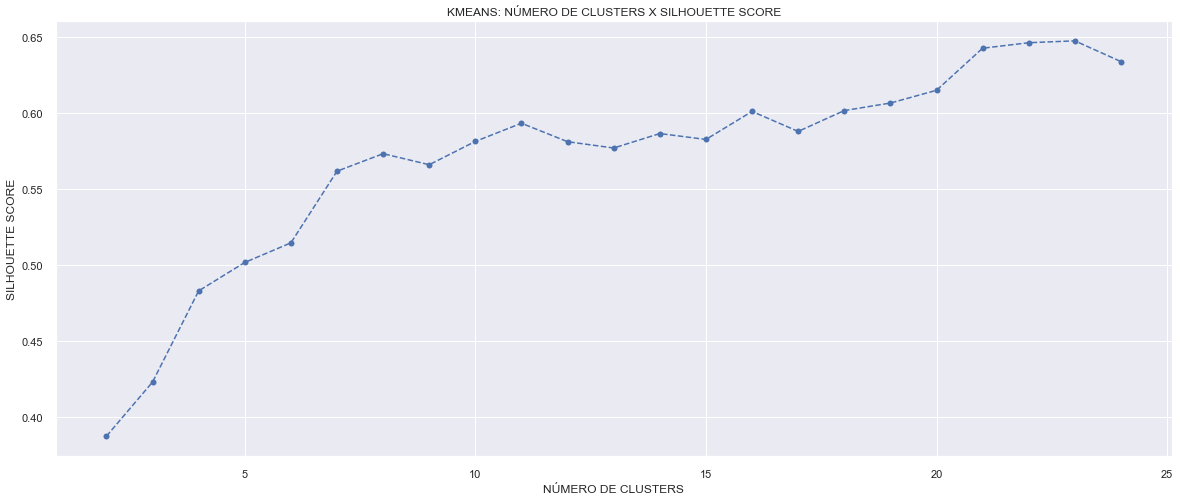

In [60]:
plt.figure(figsize=(20,8))
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('NÚMERO DE CLUSTERS')
plt.ylabel('SILHOUETTE SCORE')
plt.title('KMEANS: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

## 7.2 GMM

In [61]:
gmm_list = []
for k in clusters:

    # model definition
    
    gmm_model = mx.GaussianMixture(n_components=k)
    
    # model training
    
    gmm_model.fit(X)
    
    # model predict
    
    labels = gmm_model.predict(X)
    
    # model performance
    
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'GMM: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

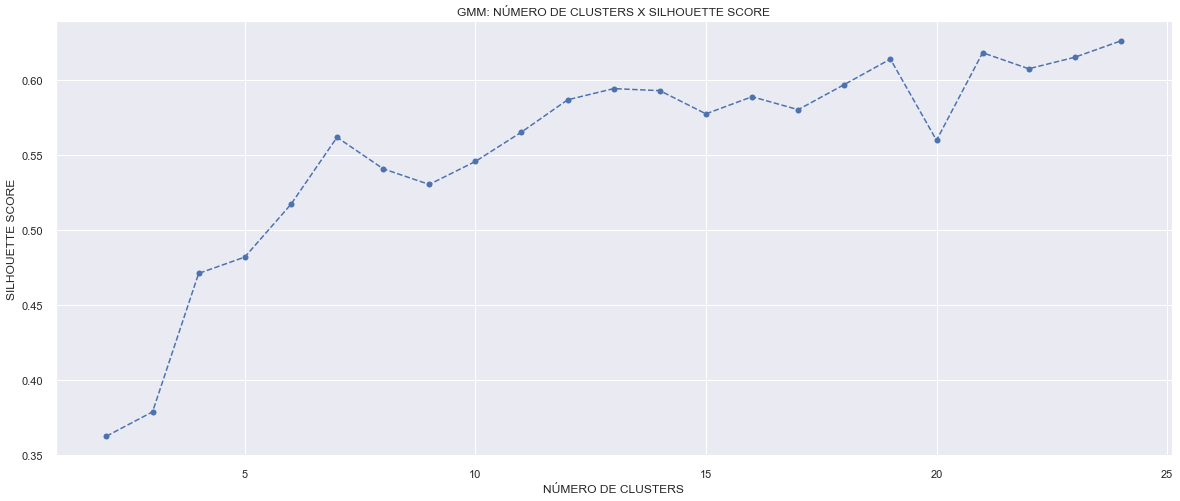

In [62]:
plt.figure(figsize=(20,8))
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('NÚMERO DE CLUSTERS')
plt.ylabel('SILHOUETTE SCORE')
plt.title('GMM: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

## 7.3 Hierarchical Clustering

In [63]:
hc_model = hc.linkage(X, 'ward')

[]

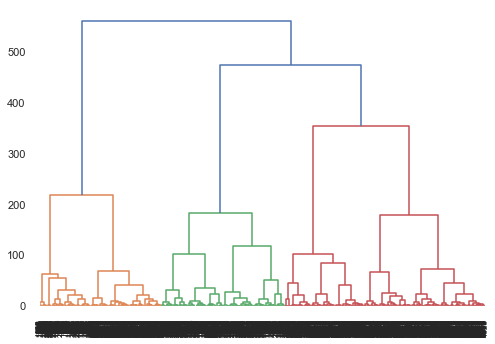

In [64]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8

    )

plt.plot()

In [65]:
hc_list = []
for k in clusters:

    # model definition & training
    
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)


Text(0.5, 1.0, 'HIERÁRQUICO: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

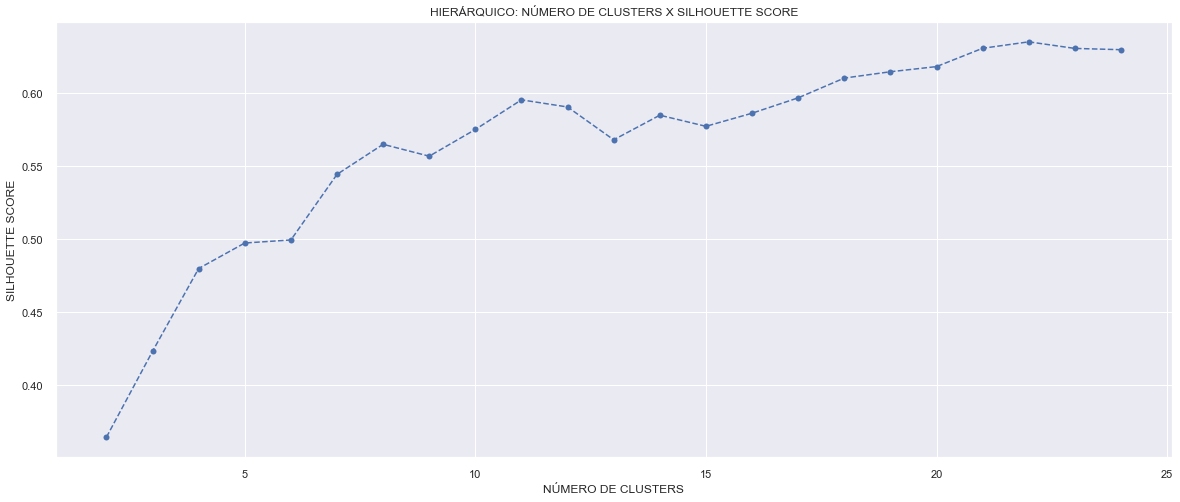

In [66]:
plt.figure(figsize=(20,8))
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('NÚMERO DE CLUSTERS')
plt.ylabel('SILHOUETTE SCORE')
plt.title('HIERÁRQUICO: NÚMERO DE CLUSTERS X SILHOUETTE SCORE')

## 7.4 DBSCAN

In [67]:
eps=0.1
min_samples=20

# model definition

dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training & predict

labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric='euclidean')
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
print( np.unique( labels ) )

Silhouette Score: -0.5492607951164246
Number of Clusters: 11
[-1  0  1  2  3  4  5  6  7  8  9]


In [68]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

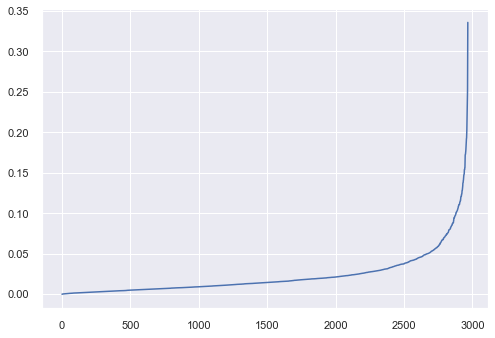

In [69]:
 distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

In [70]:
dbscan_list = [  0.000000, 0.000000, 0.53694, 0.000000, 0.000000, 0.000000]

## 7.5 Resultados

In [71]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list
#     'DBSCAN': dbscan_list
    }

).T

df_results.columns = clusters

In [72]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.387256,0.422918,0.482971,0.501711,0.514612,0.561828,0.573358,0.566088,0.581447,0.593412,0.581249,0.577098,0.586617,0.582729,0.601194,0.588021,0.601764,0.606726,0.615112,0.642834,0.646454,0.647692,0.634023
GMM,0.362796,0.379009,0.471194,0.482056,0.517147,0.561828,0.540857,0.530413,0.545719,0.565282,0.586779,0.594243,0.592886,0.577437,0.588843,0.580217,0.596937,0.613904,0.559840,0.618133,0.607459,0.615119,0.626048
HC,0.364567,0.423403,0.480098,0.497570,0.499650,0.544588,0.565173,0.557043,0.575339,0.595630,0.590734,0.568259,0.585108,0.577499,0.586473,0.597002,0.610542,0.614874,0.618407,0.630952,0.635358,0.630862,0.629980


 For K = 2. Silhouette Score: 0.3645670711994171
 For K = 3. Silhouette Score: 0.4234030246734619
 For K = 4. Silhouette Score: 0.48009777069091797
 For K = 5. Silhouette Score: 0.4975701868534088
 For K = 6. Silhouette Score: 0.49965041875839233
 For K = 7. Silhouette Score: 0.5445875525474548
 For K = 8. Silhouette Score: 0.5651731491088867
 For K = 9. Silhouette Score: 0.5570428371429443
 For K = 10. Silhouette Score: 0.5753387212753296
 For K = 11. Silhouette Score: 0.5956302285194397
 For K = 12. Silhouette Score: 0.5907344222068787
 For K = 13. Silhouette Score: 0.5682587623596191
 For K = 14. Silhouette Score: 0.5851083993911743
 For K = 15. Silhouette Score: 0.5774989128112793
 For K = 16. Silhouette Score: 0.5864729881286621
 For K = 17. Silhouette Score: 0.5970020294189453
 For K = 18. Silhouette Score: 0.6105424761772156
 For K = 19. Silhouette Score: 0.6148735284805298
 For K = 20. Silhouette Score: 0.6184070110321045
 For K = 21. Silhouette Score: 0.6309518218040466
 For K

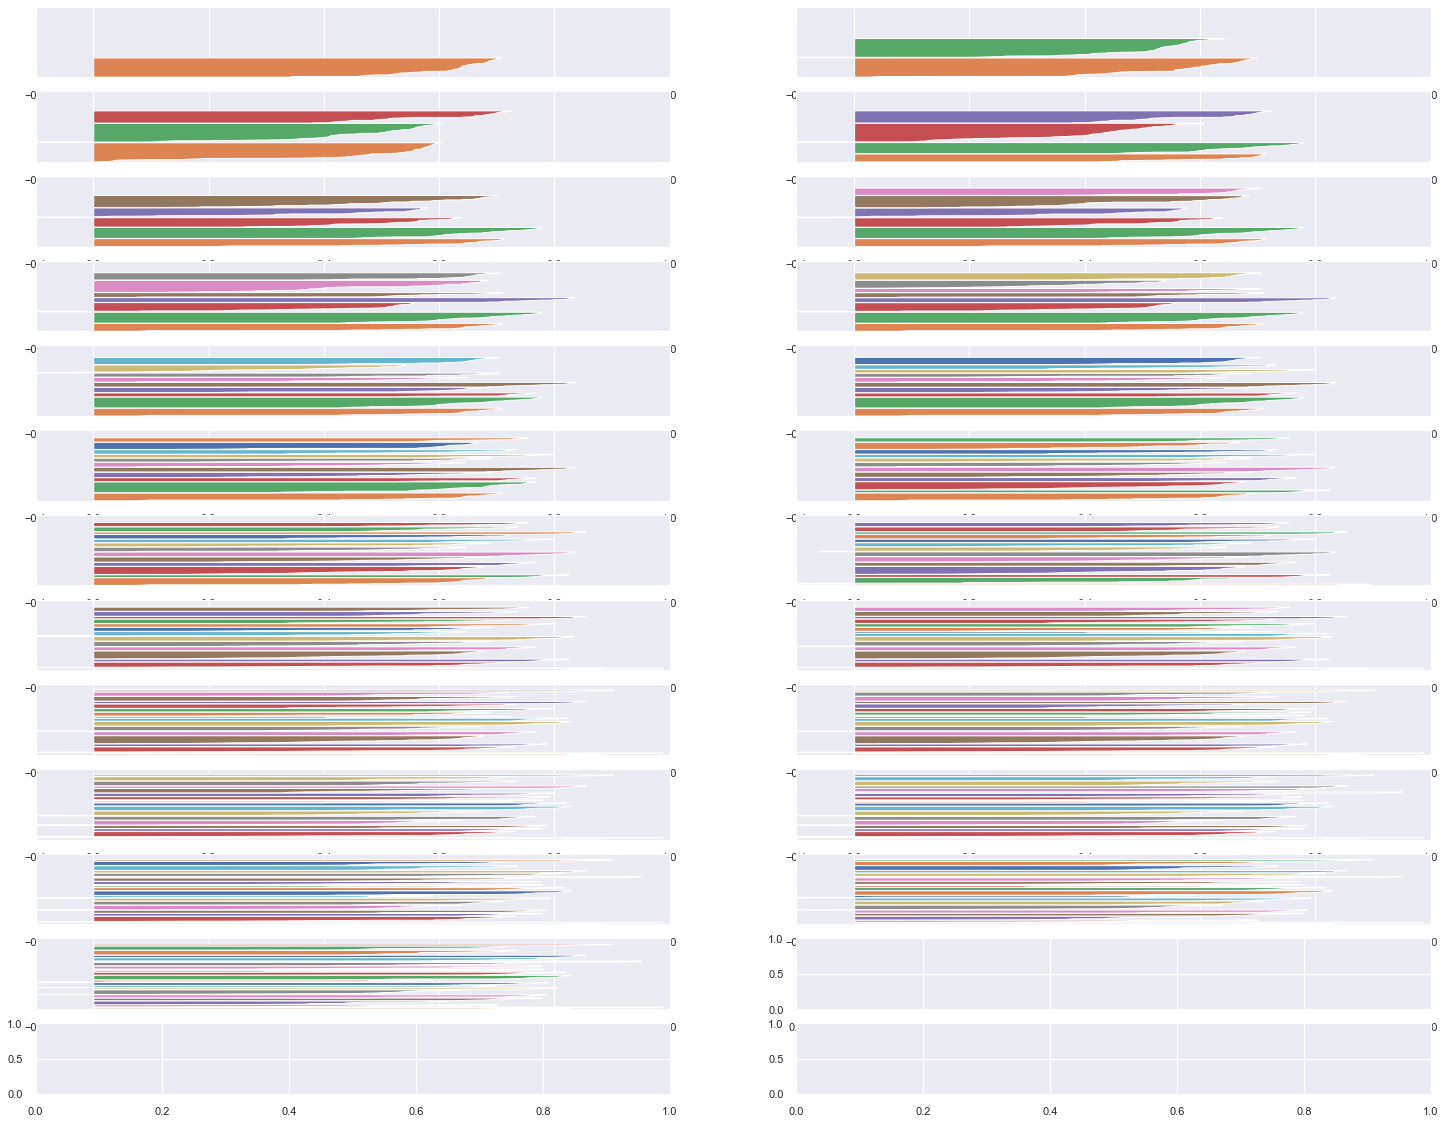

In [77]:
fig, ax = plt.subplots( 13, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0 MODEL TRAINING

## 8.1 K-Means

In [ ]:
## model definition
#
#k = 7
#
#kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
#
## model training
#
#kmeans.fit(X)
#
#
## clustering
#
#labels = kmeans.labels_

In [78]:
# teste gmm
k=9
# model definition
kmeans = mx.GaussianMixture( n_components=k )

# model training
kmeans.fit( X )

# model predict
labels = kmeans.predict( X )

## 8.2 Cluster Validation

In [80]:
#from sklearn import metrics as m
#
### WSS 
#
#print('WSS value: {}'.format(kmeans.inertia_))
#
### SS
#
#print( 'SS value: {}'.format(m.silhouette_score( X, labels, metric='euclidean' ) ) )

# 9.0 ANÁLISE DE CLUSTER

In [81]:
X.head()

,embedding_x,embedding_y
0,-0.707607,15.746873
1,4.932468,-1.578209
2,-0.972332,12.778666
3,-8.061130,4.227278
4,19.736347,12.075406


In [82]:
df9 = X.copy()

df9['cluster'] = labels

In [83]:
#df9 = df4.copy()

#df9['cluster'] = labels

#df9.head()

## 9.1 Inspeção visual

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

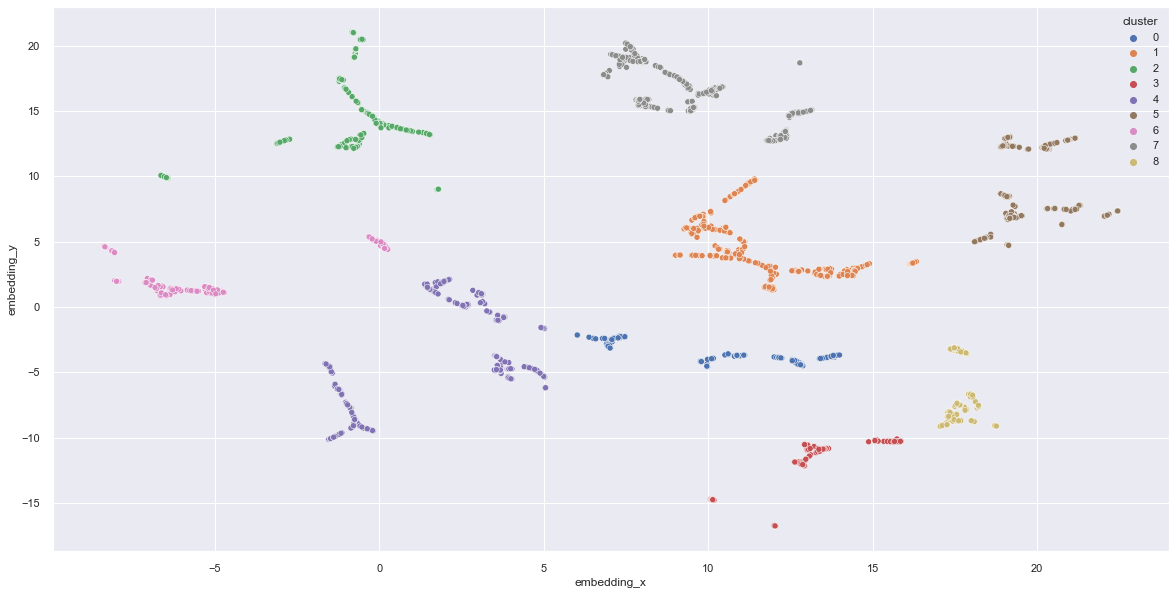

In [84]:
plt.figure(figsize=(20,10))

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [85]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit( X )
#visualizer.finalize()

## 9.2 UMAP







In [88]:
#df_viz = df9.drop( columns='customer_id', axis=1 )
#reducer = umap.UMAP(n_neighbors=80, random_state=42)
#embedding = reducer.fit_transform(X)
#
## embedding
#
#df_viz['embedding_x'] = embedding[:,0]
#df_viz['embedding_y'] = embedding[:,1]
#
## plot UMAP
#
#sns.scatterplot(x='embedding_x', 
#                y='embedding_y', 
#                hue='cluster',
#                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
#                data=df_viz              
#               
#               )

## 9.3 Cluster profile

In [89]:
df9.head()

,embedding_x,embedding_y,cluster
0,-0.707607,15.746873,2
1,4.932468,-1.578209,4
2,-0.972332,12.778666,2
3,-8.061130,4.227278,6
4,19.736347,12.075406,5


In [91]:
## número de clientes
#
#df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
#df_cluster['perc_customer'] = df_cluster['customer_id'] / (df_cluster['customer_id'].sum()) * 100
#
## avg gross revenue
#df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )
#
## avg recency days
#df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )
#
## avg invoice_no
#df_invoice_no = df9[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )
#
## frequencia
#df_invoice_no = df9[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )
#
## returns
#df_invoice_no = df9[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )
#
#df_cluster

### Cluster 01:  ( Candidato à Insider )

- Número de customers: 6 (0.14% do customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares


### Cluster 02:

- Número de customers: 4.335 (99% do customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

### Cluster 03:

- Número de customers: 31 (0.71 do customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares